<a href="https://colab.research.google.com/github/hcarlens/DQN/blob/master/Simple_DQN_on_Cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# import the necessary packages
import numpy as np
import pandas as pd
import gym
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from collections import deque
%matplotlib notebook

In [4]:
# set hyperparameters (mostly taken from DQN paper)
num_episodes = 50
max_num_steps = 200
start_epsilon = 1
end_epsilon = 0.01
epsilon_decay_rate = 0.99
discount_rate = 0.99
batch_size = 200
optimizer_learning_rate = 0.00025
buffer_length = 50000
target_update_steps = 1000

# observed standard deviations on an earlier training run
stddevs = [0.686056, 0.792005, 0.075029, 0.414541]

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
# define Q-network (two layers with 32 neurons each)
# 4 inputs (one for each scalar observable) +1 to represent the action
# todo: change to 4 inputs; 5 outputs to require fewer forward passes
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(32, activation=tf.nn.relu,
                       input_shape=(5,)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(learning_rate=optimizer_learning_rate)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [51]:
# define a memory buffer
# todo: add other types of sampling (e.g. PER, HER)
class MemoryBuffer:
  def __init__(self):
    self.memories = deque(maxlen=buffer_length)

  def add_memory(self, memory):
    self.memories.append(memory)
    
  def sample_minibatch(self, batch_size):
    return random.sample(self.memories, min(len(self.memories), batch_size))

In [57]:
def parse_minibatch(minibatch, target_network):
    minibatch = pd.DataFrame(memory_buffer.sample_minibatch(32), 
                columns=['observation', 'action', 'reward', 'next_state', 'done'])

    # get max q values for the next state
    # todo: clean this up! 
    # Can probably do this just with tensors rather than going via a pandas dataframe
    inputs = pd.DataFrame(minibatch.next_state.tolist())
    inputs['zeros'] = 0
    inputs['ones'] = 1
    next_value_0 = target_network.predict(inputs[[0,1,2,3,'zeros']])
    next_value_1 = target_network.predict(inputs[[0,1,2,3,'ones']])

    # calculate target q alues
    minibatch['next_state_max_q'] = np.maximum(next_value_0, next_value_1)
    minibatch.loc[minibatch.done, 'next_state_max_q'] = 0
    minibatch['target_q_value'] = minibatch.reward + discount_rate * minibatch.next_state_max_q

    nn_inputs = pd.DataFrame(minibatch.observation.tolist())
    nn_inputs['action'] = minibatch.action

    return nn_inputs.values, minibatch.target_q_value.tolist()

In [60]:
#todo: move some of these properties into a separate agent class

class Trainer:
    def __init__(self, env, q_network, target_network, memory_buffer, epsilon, obs_normalisation=[1,1,1,1], logdir='/logs'):
        self.q_network = q_network
        self.target_network = target_network
        self.memory_buffer = memory_buffer
        self.env = env
        self.total_steps = 0
        self.episode_lengths = []
        self.epsilon = epsilon
        
        self.obs_normalisation = obs_normalisation
        print('Trainer initialised')
        
    def run(self, num_episodes):
        # run through episodes
        for e in range(num_episodes):
            observation = self.env.reset()
            observation = np.divide(observation, self.obs_normalisation)

            for t in range(max_num_steps):
                # set the target network weights to be the same as the q-network ones every so often
                if self.total_steps % target_update_steps == 0:
                    self.target_network.set_weights(q_network.get_weights())

                # with probability epsilon, choose a random action
                # otherwise use Q-network to pick action 
                if random.uniform(0, 1) < self.epsilon:
                    action = self.env.action_space.sample()
                else:
                    input = np.array([np.append(observation,0), np.append(observation,1)])
                    action = np.argmax(self.q_network.predict(input))

                next_observation, reward, done, info = env.step(action)

                # add memory to buffer
                memory = (observation, action, reward, next_observation, done)
                self.memory_buffer.add_memory(memory)

                # sample a minibatch of experiences and update q-network
                minibatch = memory_buffer.sample_minibatch(batch_size)
                minibatch_inputs, minibatch_q_values = parse_minibatch(minibatch, self.target_network)
                self.q_network.fit(np.array(minibatch_inputs), np.array(minibatch_q_values), verbose=0)

                observation = next_observation
                self.total_steps += 1
                if done or t == max_num_steps - 1:
                    break 

            self.episode_lengths.append(t)

            if e % 10 == 0:
                print("Episode {} finished after {} timesteps. 100 ep running avg {}. Epsilon {}. Memory buffer length {}.".format(e, t+1, np.floor(np.average(self.episode_lengths[-100:])), self.epsilon, len(self.memory_buffer.memories)))

            # decrease epsilon value
            self.epsilon = max(self.epsilon * epsilon_decay_rate, end_epsilon)

In [61]:
# todo: add tensorboard logging
# initialise environment, required objects, and some variables
env = gym.make('CartPole-v0')

q_network = build_model()
target_network = build_model()
memory_buffer = MemoryBuffer()

trainer = Trainer(env=env, q_network=q_network, target_network=target_network, memory_buffer=memory_buffer, epsilon=start_epsilon, obs_normalisation=stddevs)
trainer.run(num_episodes)

Trainer initialised


ValueError: Error when checking input: expected dense_132_input to have shape (5,) but got array with shape (1,)

Text(0.5, 1.0, 'Double DQN; two 32-neuron layers; 0.00025 lr')

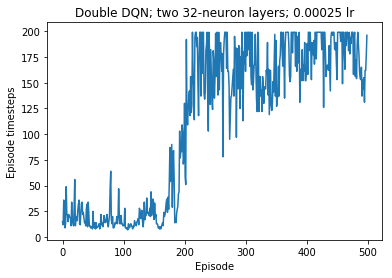

In [23]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(trainer.episode_lengths,label='episode length')
ax.set_xlabel('Episode')
ax.set_ylabel('Episode timesteps')
ax.set_title('Double DQN; two 32-neuron layers; batch size 200; 0.00025 lr')